$\newcommand\E{{\mathbf E}}$
$\newcommand\indi[1]{{\mathbf 1}_{\displaystyle #1}}$
$\newcommand\inde[1]{{\mathbf 1}_{\displaystyle\left\{ #1 \right\}}}$
$\newcommand{\ind}{\inde}$
$\newcommand{\N}{{\mathbb N}}$
$\newcommand{\P}{{\mathbb P}}$
$\newcommand{\R}{{\mathbb R}}$
$\newcommand{\Z}{{\mathbb Z}}$

<h1 align="center">Méthode de monte-carlo pour le pricing d'option</h1>
<h2 align="center">Le modèle de Black et Scholes</h2>
<h3 align="center">Bernard Lapeyre, Octobre  2018</h3>

## 1. Préliminaires

__Question 1.1.__ Ecrire une fonction __Python__ qui calcule la moyenne
  empirique `Moyenne`, la variance empirique `Variance`
  empirique d'un tableau de nombre.
  
Vérifiez qu'elles coïncident (presque) avec les fonctions prédéfinies de __Python__: `np.mean`, `np.var`.

In [1]:
import numpy as np;
import math;
import scipy.stats as stats;
import random;
import matplotlib.pyplot as plt;

def moyenne(x):
  res=sum(x)/len(x)
  return res


def Variance(x):
  res = moyenne((x-moyenne(x))**2)
  N = np.size(x)
  return res*N/(N-1)

In [4]:
n=1000
x=np.random.rand(n) # n tirages uniforme sur [0,1]
print('Mes functions : ',moyenne(x),Variance(x))
print('Celles de numpy : ',np.mean(x),np.var(x))

Mes functions :  0.4870183680402107 0.085612175892366
Celles de numpy :  0.48701836804021076 0.08552656371647369


 __Question 1.2.__ Ecrire une fonction permettant de simuler un vecteur consitué
  de variables aléatoires gaussiennes centrées réduites indépendantes.

  Tracer l'histogramme du vecteur obtenu et verifier qu'il correspond bien
  à la loi gaussienne centrée réduite. 

  Cette fonction existe dans __Python__ : `np.random.normal(size=n)`.


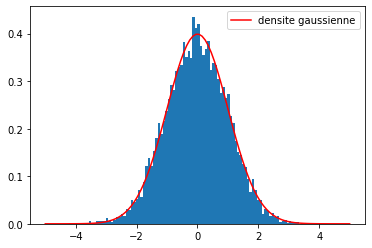

In [11]:
def gauss(N):
  U=np.random.rand(N)# U est un vecteur (1,n)
  V=np.random.rand(N)# V est un vecteur (1,n)
  return np.sqrt(-2*np.log(U))*np.cos(2*np.pi*V)

# On trace la densité de la gaussienne centrée réduite
x = np.linspace(-5,5,100)
densiteGaussienne = 1./np.sqrt(2*np.pi)*np.exp(-0.5*x**2)
plt.plot(x, densiteGaussienne, color="red", label="densite gaussienne")
plt.legend(loc="best")

# On superpose avec une densite empirique (obtenue par simulation)
X=gauss(10000)  # notre tirage gaussien
                # on aurait pu utiliser X = np.random.normal(size=10000)
                # qui fait le meme chose
plt.hist(X, density="True", bins=100, label="erreur normalisee");

__Question 1.3.__ On cherche à calculer par simulation $\E(e^{\beta G})$ où $G$
  est une gaussienne centrée réduite. On rappelle que $\E(e^{\beta
    G})=\exp(\beta^2/2)$.

  Calculer par simulation $\E(e^{\beta G})$ pour
  $\beta=2,4,6,8,10\ldots$. Précisez à chaque fois une intervalle de
  confiance. Pour quelles valeurs de $\beta$ peut on utiliser cette
  méthode de monte-carlo ?

In [28]:
def test_1(N,b):
  X=np.exp(b*np.random.normal(size=N))

  estimation=np.mean(X);
  erreur_estimee= X - estimation
  valeur_exacte = np.exp(b*b/2);
  erreur = np.abs(estimation-valeur_exacte)/valeur_exacte;
  print("N=",N,", Valeur = ",'{0:.2f}'.format(estimation)," Erreur relative = ", '{0:.1f}'.format(100 * erreur),"%")

test_1(100000,1);
test_1(100000,2);
test_1(100000,4);
test_1(100000,6);
test_1(100000,8);
test_1(1000000,8);


N= 100000 , Valeur =  1.63  Erreur relative =  1.0 %
N= 100000 , Valeur =  7.39  Erreur relative =  0.0 %
N= 100000 , Valeur =  2444.85  Erreur relative =  18.0 %
N= 100000 , Valeur =  2387235.83  Erreur relative =  96.4 %
N= 100000 , Valeur =  293421174538.91  Erreur relative =  99.6 %
N= 1000000 , Valeur =  91013504830.59  Erreur relative =  99.9 %


## 2. Le modèle de Black et Scholes

On considère le modèle de Black et Scholes :
$$
  S_t = S_0 \exp\left(\left(r-\frac{\sigma^2}{2}\right)t + \sigma W_t\right).
$$
On supposera dans la suite que $S_0=100$, 
$\sigma=0.3$ (volatilité annuelle) et $r=0.05$ (taux d'intérêt
exponentiel annuel).

__Question 2.1.__ Tracer l'histogramme de la loi de $S_T$, pour $T=1$,
  $\sigma=0.3$ (volatilité annuelle) et $r=0.05$ (taux d'intérêt
  exponentiel annuel).

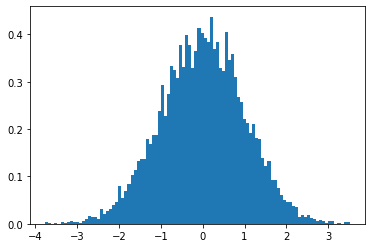

In [40]:
T=1; # an
S_0=100; 
r=0.05; # par an
sigma=0.3; # par racine d'annee sigma^2 * T  est sans dimension
K=100;

# Question 1
N=10000;
W_T=np.sqrt(T)*np.random.normal(size=N);
S_T=S_0*np.exp((r-(sigma**2/2))*T+sigma*W_T)
plt.hist(W_T, density="True", bins=100, label="erreur normalisee");

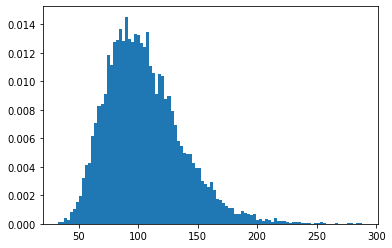

In [41]:
plt.hist(S_T, density="True", bins=100, label="erreur normalisee");

__Question 2.2.__ On cherche à calculer le prix d'un call de strike $K=100$.
  Calculer ce prix par une méthode de monte-carlo avec un nombre
  de tirages égaux à $N=1000$,$1000$,$10000$. On précisera 
  l'intervalle de confiance.

In [61]:
# Question 2
T=1; # an
S_0=100; 
r=0.05; # par an
sigma=0.3; # par racine d'annee sigma^2 * T  est sans dimension
K=100;

def stdev(payoff):
    return np.sqrt(np.var(payoff));

def call(x,K):
    return np.maximum(x-K*np.ones(np.size(x)),np.zeros(np.size(x)));

def test_call(N):
    W_T=np.sqrt(T)*np.random.normal(size=N);
    S_T=S_0*np.exp((r-sigma**2/2)*T + sigma*W_T);
    payoff=call(S_T,K)

    estimation=np.mean(payoff);  # estimation de la moyenne
    ecart_type=stdev(payoff); # estimation de l'ecart type
    erreur=1.96*ecart_type/np.sqrt(N); # demi-largeur de l'intervalle de confiance
    print('Direct N =',N,':', estimation,'+-', erreur);

test_call(100);
test_call(1000);
test_call(10000);
test_call(100000);


Direct N = 100 : 18.82397827989935 +- 4.986211200031962
Direct N = 1000 : 15.106955818531599 +- 1.487267336140701
Direct N = 10000 : 15.154798131002124 +- 0.4693688352340512
Direct N = 100000 : 15.099216761148691 +- 0.14834051002360024


 __Question 2.3.__ On va chercher à utiliser la variable aléatoire $S_T$ comme une
  variable de contrôle. Vérifiez que $\E(S_T)=S_0 e^{rT}$ (pourquoi ?).

  Ecrire un programme qui utilise $S_T$ comme variable de contrôle.
  Comparer la précision de cette méthode avec la précédente suivant les
  valeur relative de $K$ et $S_0$.

  Se convaincre que l'on a ainsi ramené le calcul du call à un calcul
  de put.

In [59]:
# Question 3
T=1; # an
S_0=100; 
r=0.05; # par an
sigma=0.3; # par racine d'annee sigma^2 * T  est sans dimension
K=100;

def put(x,K):
    return np.maximum(K*np.ones(np.size(x))-x,np.zeros(np.size(x)));

def test_call_arbitrage(N):
# C-P = S_0 - K exp(-rT)
# On peut donc construire un nouvel estimateur
# S_0 - K exp(-rT) + exp(-rT) * (K-S_T)_+

    W_T=np.sqrt(T)*np.random.normal(size=N);
    S_T=S_0*np.exp((r-sigma**2/2)*T + sigma*W_T);
    payoff= put(S_T,K)
    
    estimation=np.mean(payoff);  # estimation de la moyenne
    ecart_type=stdev(payoff); # estimation de l'ecart type
    erreur=1.96*ecart_type/np.sqrt(N); # demi-largeur de l'intervalle de confiance

    print("CallPut N=",N,": ", estimation, "+-", erreur);

K=100;test_call(10000);test_call_arbitrage(10000);
K= 80;test_call(10000);test_call_arbitrage(10000);
K= 60;test_call(10000);test_call_arbitrage(10000);


Direct N = 10000 : 5.11052843175473 +- 0.6331339264495626
CallPut N= 10000 :  9.916513733237755 +- 0.26922813723519595
Direct N = 10000 : 24.91277842497509 +- 0.6344325966465431
CallPut N= 10000 :  2.7813354394050402 +- 0.13075199320123693
Direct N = 10000 : 44.643244915798725 +- 0.6343850434333003
CallPut N= 10000 :  0.2500777406741275 +- 0.03096205995052386


__Question 2.4.__ On se place dans la cas d'un call de strike $K$ grand devant
  $S_0$.  Montrer par simulation que la précision relative du calcul
  décroit au fur et à mesure que $K/S_0$ décroit. On prendra $S_0=100$
  et $K=100$, $150$, $200$, $250$.  Que se passe t'il pour $K=400$ ?

In [63]:
# Question 4
T=1; # an
S_0=100; 
r=0.05; # par an
sigma=0.3; # par racine d'annee sigma^2 * T  est sans dimension

def precision_relative(K,N):
    W_T=np.sqrt(T)*np.random.normal(size=N);
    S_T=S_0*np.exp((r-sigma**2/2)*T + sigma*W_T);
    payoff=np.exp(-r*T) * call(S_T,K);

    estimation=np.mean(payoff);  # estimation de la moyenne
    ecart_type=stdev(payoff); # estimation de l'ecart type
    erreur=1.96*ecart_type/np.sqrt(N); # demi-largeur de l'intervalle de confiance

    erreur_relative=A_FAIRE
    print("Précision relative en % : ",100 * erreur_relative);

S_0=100;N=10000;
precision_relative(100,N)
precision_relative(150,N)
precision_relative(200,N)
precision_relative(250,N)


Précision relative en % :  3.0932305729065424
Précision relative en % :  9.054933252664235
Précision relative en % :  28.362455225320875
Précision relative en % :  76.42461343207646


__Question 2.5.__ Montrer que:
  $$
  \E\left(f(W_T)\right) 
     = \E\left(e^{-\lambda W_T -\frac{\lambda^2 T}{2}}f(W_T+\lambda T)\right).
  $$
  On se place dans le cas du call avec $S_0=100$ et $K=150$.
  Proposer une valeur de $\lambda$ permettant de réduire la variance de
  la simulation.

In [64]:
# Question 5

# La formule de Black et Scholes
# pour verifier

def NN(x):
    return stats.norm.cdf(x,0,1);

def BS_Call(S_0,K,sigma,r,T):
    d1=(math.log(S_0/K)+(r+sigma**2/2)*T)/(sigma*math.sqrt(T));
    d2=d1-sigma*np.sqrt(T);
    return S_0*NN(d1)-K*np.exp(-r*T)*NN(d2);

def test_call_girsanov(r, sigma, S_0, T, K, Lambda,N):
    W_T=math.sqrt(T)*np.random.normal(size=N);
    S_T=S_0*np.exp((r-sigma**2/2)*T + sigma*(W_T+Lambda* T));
    payoff=math.exp(-r*T) * call(S_T,K);
    importance = A_FAIRE# Pour l'importance voir la formule du texte
    payoff = importance * payoff; 

    estimation=np.mean(payoff);  # estimation de la moyenne
    ecart_type=stdev(payoff); # estimation de l'ecart type
    erreur=1.96*ecart_type/math.sqrt(N); # demi-largeur de l'intervalle de confiance
    print("Girsanov, (lambda=",Lambda,"), N=",N, " :", estimation,"+-", erreur);

T = 1; # an
S_0 = 100; 
r = 0.05; # par an
sigma = 0.3; # par racine d'annee sigma^2 * T  est sans dimension

N=5000;
K=150;
Lambda=0;# simulation naturelle, importance=1
test_call_girsanov(r, sigma, S_0, T, K, Lambda,N);

Lambda= (math.log(K/S_0)-(r-sigma**2/2)*T)/(sigma*T); # avec ce lambda avec proba 1/2,  S_T > K, condition d'exercice 
test_call_girsanov(r, sigma, S_0, T, K, Lambda,N);

# Vérification
print(BS_Call(S_0,K,sigma,r,T))

K=200;

Lambda=0;# simulation naturelle, importance=1
test_call_girsanov(r, sigma, S_0, T, K, Lambda,N);

Lambda= (math.log(K/S_0)-(r-sigma**2/2)*T)/(sigma*T);
    # avec ce lambda avec proba 1/2,  S_T > K, condition d'exercice 
test_call_girsanov(r, sigma, S_0, T, K, Lambda,N);

# Vérification
print(BS_Call(S_0,K,sigma,r,T))


Girsanov, (lambda= 0 ), N= 5000  : 2.0456436671884632 +- 0.2625316743093051
Girsanov, (lambda= 1.3348836936938813 ), N= 5000  : 2.076059977415355 +- 0.06349875219169329
2.0579856799087306
Girsanov, (lambda= 0 ), N= 5000  : 0.21399391031769718 +- 0.0737928394802455
Girsanov, (lambda= 2.2938239351998178 ), N= 5000  : 0.2368242061540815 +- 0.007694646970358862
0.23482639362510893


# 3. Modèle de Panier

On s'intéresse à un modèle de panier constitué à partir de $d$ actifs.
On suppose que chacun de ces $d$ actifs de prix $S^i_t$ suit un modèle de
black et Scholes guidé par un mouvement $W^i_t$~:
$$
   \frac{d S^i_t}{S^i_t} = r dt + \sigma dW^i_t, S^i_0=x_i.
$$
On prendra dans les applications numériques $x_i=100$ et $d=10$.

Pour déterminer complètement le modèle on doit spécifier les 
corrélation entre les mouvements browniens. Pour cela on suppose
que~:
$$
   d<W_i,W_j>_t = \rho dt,
$$
$\rho$ étant une constante donnée que l'on prendra égale à $0.5$ 
dans les simulations.


__Question 3.1__ Calculer la matrice de corrélation du vecteur
  $(W^1_T,\ldots,W^d_T)$.  Montrer qu'elle est
  définie positive.

__Question 3.2__ Proposer une méthode de simulation pour le vecteur
  $(W^1_T,\ldots,W^d_T)$ et $(S^1_T,\ldots,S^d_T)$.

 __Question 3.3__ On s'intéresse maintenant au calcul du prix d'un call sur
   un indice de prix $I_t$ donnée par
   $$
      I_t = a_1 S^1_t + \cdots + a_d S^d_t.
   $$
   On prendra dans les applications numériques $a_1=\cdots=a_d=1/d$.
   Calculer par simulation la valeur du call de payoff à l'instant $T$
   $$
      \left(I_T-K\right)_+,
   $$
   et estimer l'erreur commise dans le cas où $K=I_0$.


__Question 3.3__ Montrer une relation d'arbitrage call-put et montrer que l'on
   peut l'utiliser pour mettre en oeuvre une technique de réduction de
   variance.

__Question 3.4__ En utilisant le "théorème de Girsanov" pour les $d$ mouvements
   browniens proposer une technique de réduction de variance dans le cas
   où $I_0$ est petit devant $K$.

 __Question 3.5__ En supposant que $r$ et $\sigma$ tendent vers $0$ expliquer pourquoi
 il est raisonnable d'approximer $\log(I_t/I_0)$ par:
 $$
      a_1 S^1_0 \log(S^1_t/S^1_0) + \cdots + a_d S^d_0 \log(S^d_t/S^d_0).
 $$
 En déduire une variable de contrôle pour le calcul du prix du call.
 Évaluer par simulation le gain de la méthode. 